In [1]:
reset -fs

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import pickle
import h5py
import gzip
import dl_functions
from IPython.display import display
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### Loading data from a compressed pickle file that has 20,000 images pre-processed with a size of 25 by 25.

In [3]:
with gzip.open('pre_processed_images/image_data_20000_25.txt.gz', 'rb') as f:
  X, y = pickle.load(f)

#### Creating a train, test split.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### The labels need to be converted to categorical. Note that we have 2 categories: good (1) and bad (0) images.

In [5]:
y_train_sparse = np_utils.to_categorical(y_train, 2)

In [6]:
y_test_sparse = np_utils.to_categorical(y_test, 2)

#### Creating an instance of a CNN model.

##### The image size is 25.

In [7]:
IMG_SIZE = 25

In [8]:
model_1 = dl_functions.cnn_model_v_0(IMG_SIZE)

In [9]:
model_1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [10]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 23, 23, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 64)          0         
__________

In [11]:
model_1.fit(X_train, y_train_sparse, batch_size=128, epochs=50, verbose=1, validation_split=0.3)

Train on 9800 samples, validate on 4200 samples
Epoch 1/50
9800/9800 [==============================] - 13s - loss: 0.6381 - acc: 0.6388 - val_loss: 0.5915 - val_acc: 0.7038
Epoch 2/50
9800/9800 [==============================] - 12s - loss: 0.5671 - acc: 0.7076 - val_loss: 0.5111 - val_acc: 0.7455
Epoch 3/50
9800/9800 [==============================] - 12s - loss: 0.5329 - acc: 0.7394 - val_loss: 0.5175 - val_acc: 0.7498
Epoch 4/50
9800/9800 [==============================] - 13s - loss: 0.5011 - acc: 0.7636 - val_loss: 0.5572 - val_acc: 0.7231
Epoch 5/50
9800/9800 [==============================] - 12s - loss: 0.4870 - acc: 0.7721 - val_loss: 0.4700 - val_acc: 0.7688
Epoch 6/50
9800/9800 [==============================] - 13s - loss: 0.4749 - acc: 0.7772 - val_loss: 0.4861 - val_acc: 0.7774
Epoch 7/50
9800/9800 [==============================] - 12s - loss: 0.4570 - acc: 0.7885 - val_loss: 0.6760 - val_acc: 0.6243
Epoch 8/50
9800/9800 [==============================] - 13s - loss: 0.

In [12]:
score = model_1.evaluate(X_test, y_test_sparse, verbose=1)

6000/6000 [==============================] - 2s     


In [13]:
print('Test loss: {:0,.4f}'.format(score[0]))
print('Test accuracy: {:.2%}'.format(score[1]))

Test loss: 0.5173
Test accuracy: 80.10%


In [14]:
model_1.save('models/model_v0_20000_25.h5')

In [15]:
model_1.save_weights('models/model_v0_20000_25_weights.h5')

#### Creating a list of predictions.

In [16]:
predicted_images = []
for i in model_1.predict(X_test):
  predicted_images.append(np.where(np.max(i) == i)[0])

#### Displaying a confusion matrix.

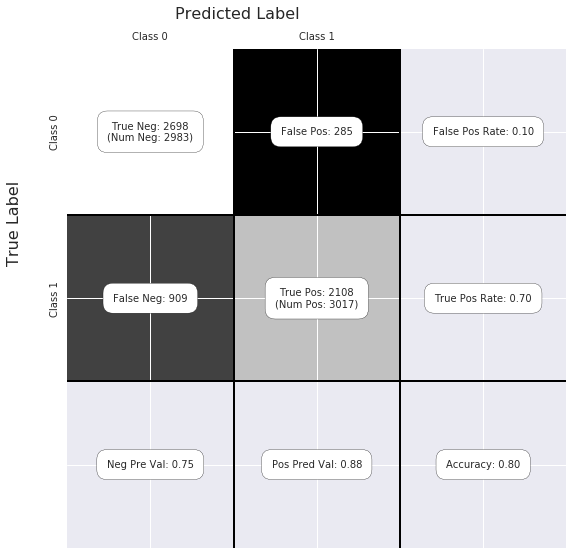

In [17]:
dl_functions.show_confusion_matrix(confusion_matrix(y_test, predicted_images), ['Class 0', 'Class 1'])

In [18]:
pd.DataFrame(confusion_matrix(y_test, predicted_images),columns = ['nok_image','ok_image'])

,nok_image,ok_image
0,2698,285
1,909,2108


In [19]:
print("AUC: {:.2%}\n".format(roc_auc_score(y_test, predicted_images)))

AUC: 80.16%



In [20]:
predictions_probability = model_1.predict_proba(X_test)

5920/6000 [============================>.] - ETA: 0s

#### Plotting a ROC curve.

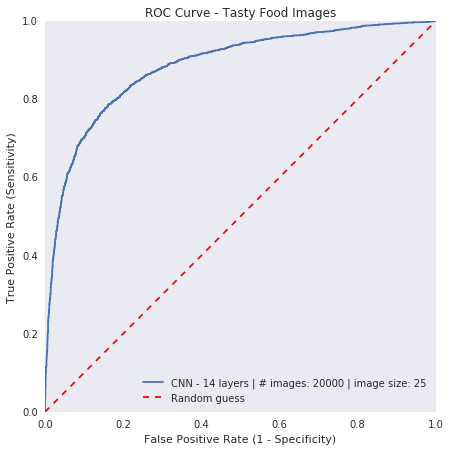

In [21]:
plt.figure(figsize=(7, 7))
dl_functions.plot_roc(y_test, predictions_probability[:,1], "CNN - " + str(len(model_1.layers)) + " layers | # images: " + str(len(X)) + " | image size: " + str(IMG_SIZE), "Tasty Food Images")

### Prediction using an image of Donald Trump.
<img src='images/trump_1.jpg' />

In [22]:
trump = dl_functions.normalize_images_array('images', IMG_SIZE)

In [23]:
trump_prediction = model_1.predict_classes(trump)

1/1 [==============================] - 0s


In [24]:
trump_prediction[0]

0

In [25]:
trump.shape

(1, 25, 25, 3)

In [26]:
trump = trump.reshape(trump.shape[1], trump.shape[2], trump.shape[3])

#### The model predicts the image as bad.

In [27]:
img = array_to_img(trump)
display(img)

### Training another CNN model.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
y_train_sparse = np_utils.to_categorical(y_train, 2)

In [30]:
y_test_sparse = np_utils.to_categorical(y_test, 2)

In [31]:
model_2 = dl_functions.cnn_model_v_1(IMG_SIZE)

In [32]:
model_2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [33]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 23, 23, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
__________

In [34]:
model_2.fit(X_train, y_train_sparse, batch_size=128, epochs=50, verbose=1, validation_split=0.3)

Train on 9800 samples, validate on 4200 samples
Epoch 1/50
9800/9800 [==============================] - 5s - loss: 0.6383 - acc: 0.6382 - val_loss: 0.5725 - val_acc: 0.7314
Epoch 2/50
9800/9800 [==============================] - 5s - loss: 0.5705 - acc: 0.7121 - val_loss: 0.5552 - val_acc: 0.7264
Epoch 3/50
9800/9800 [==============================] - 5s - loss: 0.5294 - acc: 0.7403 - val_loss: 0.4955 - val_acc: 0.7688
Epoch 4/50
9800/9800 [==============================] - 5s - loss: 0.5168 - acc: 0.7478 - val_loss: 0.4857 - val_acc: 0.7738
Epoch 5/50
9800/9800 [==============================] - 5s - loss: 0.4995 - acc: 0.7648 - val_loss: 0.4631 - val_acc: 0.7826
Epoch 6/50
9800/9800 [==============================] - 5s - loss: 0.4885 - acc: 0.7711 - val_loss: 0.4722 - val_acc: 0.7817
Epoch 7/50
9800/9800 [==============================] - 5s - loss: 0.4739 - acc: 0.7810 - val_loss: 0.4655 - val_acc: 0.7795
Epoch 8/50
9800/9800 [==============================] - 5s - loss: 0.4674 - a

In [35]:
score = model_2.evaluate(X_test, y_test_sparse, verbose=1)

5888/6000 [============================>.] - ETA: 0s

In [36]:
print('Test loss: {:0,.4f}'.format(score[0]))
print('Test accuracy: {:.2%}'.format(score[1]))

Test loss: 0.9984
Test accuracy: 74.77%


In [37]:
model_2.save('models/model_v1_20000_25.h5')

In [38]:
model_2.save_weights('models/model_v1_20000_25_weights.h5')

In [39]:
predicted_images = []
for i in model_2.predict(X_test):
  predicted_images.append(np.where(np.max(i) == i)[0])

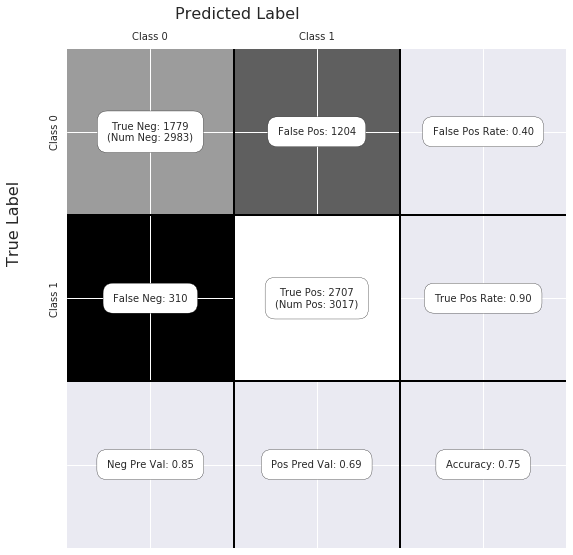

In [40]:
dl_functions.show_confusion_matrix(confusion_matrix(y_test, predicted_images), ['Class 0', 'Class 1'])

In [41]:
pd.DataFrame(confusion_matrix(y_test, predicted_images),columns = ['nok_image','ok_image'])

,nok_image,ok_image
0,1779,1204
1,310,2707


In [42]:
print("AUC: {:.2%}\n".format(roc_auc_score(y_test, predicted_images)))

AUC: 74.68%



In [43]:
predictions_probability = model_2.predict_proba(X_test)

5792/6000 [===========================>..] - ETA: 0s

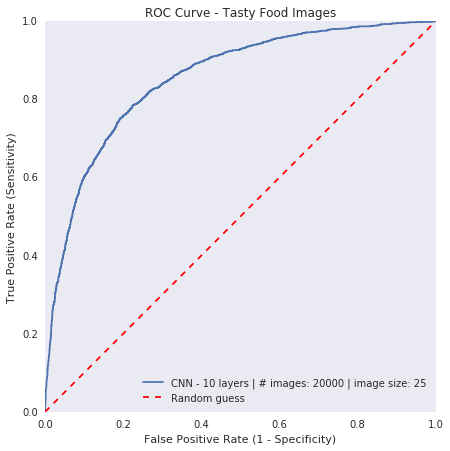

In [44]:
plt.figure(figsize=(7, 7))
dl_functions.plot_roc(y_test, predictions_probability[:,1], "CNN - " + str(len(model_2.layers)) + " layers | # images: " + str(len(X)) + " | image size: " + str(IMG_SIZE), "Tasty Food Images")

### Prediction using an image of Donald Trump.
<img src='images/trump_1.jpg' />

In [45]:
trump = dl_functions.normalize_images_array('images', IMG_SIZE)

In [46]:
trump_prediction = model_2.predict_classes(trump)

1/1 [==============================] - 0s


In [47]:
trump_prediction[0]

0

In [48]:
trump.shape

(1, 25, 25, 3)

In [49]:
trump = trump.reshape(trump.shape[1], trump.shape[2], trump.shape[3])

#### The model predicts the image as NOK.

In [50]:
img = array_to_img(trump)
display(img)

In [51]:
!gsutil cp -r 'models' 'gs://wellio-kadaif-tasty-images-project-pre-processed-images'

Copying file://models/model_v1_20000_25_weights.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v2_20000_50.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v1_20000_50_weights.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v1_20000_100_weights.h5 [Content-Type=application/octet-stream]...
\ [4 files][ 16.5 MiB/ 16.5 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m -o ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://models/model_v0_20000_100_weights.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v1_20000_25.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v0_20000_25_weights.h5 [Content-Type=application/octet-stream]...
Copying file://models/m